# TFM:
## Lectura de los datos:
Primero leemos los datos del archivo desastres_asia.csv, y guardamos en dos DataFrames distintos los datos de terremotos y de inundaciones.

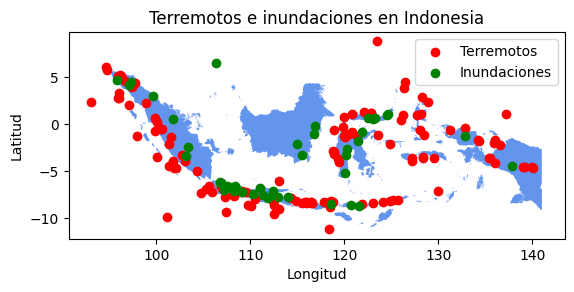

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
import geopandas as gpd

geopandas_indonesia = 'indonesia.gpkg'
df_plot = gpd.read_file(geopandas_indonesia)

data=pd.read_csv('desastres_asia.csv')

columns=['Magnitude',
         'Latitude',
         'Longitude',
         'Start Year',
         'Start Month',
         'Start Day',
         'Total Affected']

columns2=['Magnitude']

eq_ind=data.query("Country == 'Indonesia' & `Disaster Type`== 'Earthquake'")
eq_ind=eq_ind[columns]
eq_ind[['Start Month','Start Day']]=eq_ind[['Start Month','Start Day']].fillna(1)
eq_ind['Fecha']=pd.to_datetime(eq_ind['Start Year'].astype(str)+'-'+eq_ind['Start Month'].astype(int).astype(str)+'-'+eq_ind['Start Day'].astype(int).astype(str))
eq_ind[columns2]=eq_ind[columns2].fillna(0)
eq_ind=eq_ind.dropna()
eq_ind=eq_ind.query("Latitude < 20 & Longitude > 50")

fd_ind=data.query("Country == 'Indonesia' & `Disaster Type`== 'Flood'")
fd_ind=fd_ind[columns]
fd_ind[['Start Month','Start Day']]=fd_ind[['Start Month','Start Day']].fillna(1)
fd_ind['Fecha']=pd.to_datetime(fd_ind['Start Year'].astype(str)+'-'+fd_ind['Start Month'].astype(int).astype(str)+'-'+fd_ind['Start Day'].astype(int).astype(str))
fd_ind[columns2]=fd_ind[columns2].fillna(0)
fd_ind=fd_ind.dropna()

long_terr=list(eq_ind['Longitude'])
lat_terr=list(eq_ind['Latitude'])

long_ind=list(fd_ind['Longitude'])
lat_ind=list(fd_ind['Latitude'])

fig, ax = plt.subplots()

df_plot.plot(ax=ax, color='cornflowerblue')

plt.scatter(long_terr,lat_terr,label='Terremotos',color='red')
plt.scatter(long_ind,lat_ind,label='Inundaciones',color='green')
plt.legend()
plt.title('Terremotos e inundaciones en Indonesia')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

Definimos una función auxiliar que nos servirá más adelante para hallar el radio de afectación de un terremoto en función de su magnitud:

In [ ]:
print('Radios de afectación Inundaciones:')
fd_ind['Radio afectación']=np.sqrt(fd_ind['Magnitude']/np.pi)
print(fd_ind['Radio afectación'].describe())

def rad(x):
    if x<6:
        return 10
    elif x<7:
        return 100
    elif x<8:
        return 250
    else:
        return 700

print('\nRadios de afectación Terremotos:')
eq_ind['Radio afectación']=[rad(x) for x in eq_ind['Magnitude']]
print(eq_ind['Radio afectación'].describe())
print(fd_ind['Magnitude'].describe())

Radios de afectación Inundaciones:
count     46.000000
mean      77.745484
std       57.712894
min        0.000000
25%       31.563301
50%       76.083420
75%      104.366881
max      273.977096
Name: Radio afectación, dtype: float64

Radios de afectación Terremotos:
count    128.00000
mean     144.53125
std      143.05915
min       10.00000
25%      100.00000
50%      100.00000
75%      250.00000
max      700.00000
Name: Radio afectación, dtype: float64
count        46.000000
mean      29225.388913
std       42354.142832
min           0.000000
25%        3130.000000
50%       18195.500000
75%       34220.000000
max      235818.780000
Name: Magnitude, dtype: float64


##Análisis clústering:
Ahora vamos a hacer un clústering de los datos usando el algoritmo Kmeans para encontrar las regiones en las que los desastres se reparten. Haremos el cústering primero con los terremotos y luego con las inundaciones.
Como criterio para determinar el número de clústers que introduciremos al algoritmo Kmeans usaremos la regla del codo y el coeficiente de Silhouette.

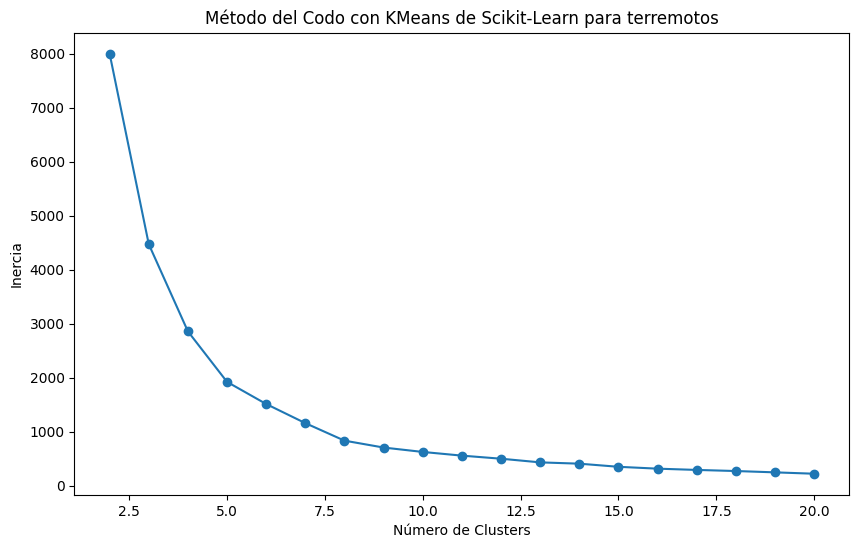

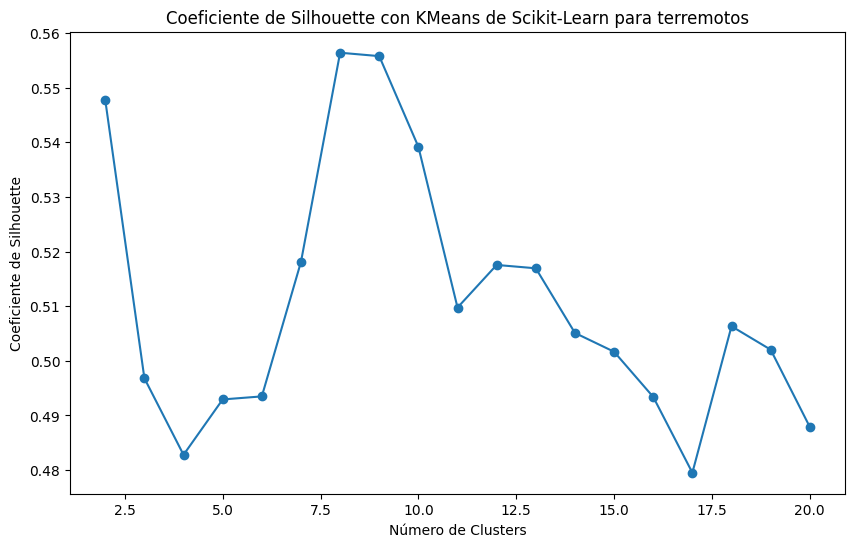

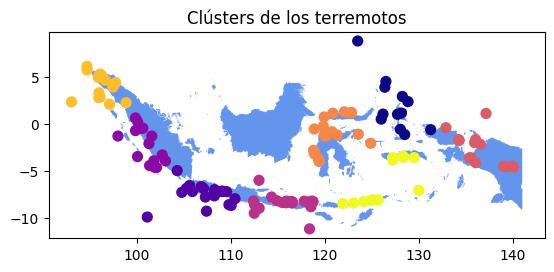

In [ ]:

"""Terremotos"""
X_terr=np.array([(long_terr[i],lat_terr[i]) for i in range(len(long_terr))])

# Rango de números de clusters a probar
num_clusters_range = range(2, 21)

# Lista para almacenar la menor inercia para cada número de clusters
l_inercias=[]
l_silhouette=[]

# Calcular la inercia para cada número de clusters
for k in num_clusters_range:
    # Ejecutar KMeans con diferentes inicializaciones y escoger el mejor resultado
    model = KMeans(n_clusters=k,n_init=10, random_state=0)
    model.fit(X_terr)
    l_inercias.append(model.inertia_)
    silhouette = metrics.silhouette_score(X_terr, model.labels_)
    l_silhouette.append(silhouette)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, l_inercias, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo con KMeans de Scikit-Learn para terremotos')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, l_silhouette, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette con KMeans de Scikit-Learn para terremotos')
plt.show()

n_cl_terr = 8

# Entrenar el modelo k-means con 10 clústeres
kmeans = KMeans(n_clusters=n_cl_terr,n_init=10)
kmeans.fit(X_terr)

# Obtener las etiquetas de los puntos
y_kmeans = kmeans.predict(X_terr)


fig, ax = plt.subplots()

df_plot.plot(ax=ax, color='cornflowerblue')

# Visualizar los datos coloreados por las etiquetas
plt.scatter(X_terr[:, 0], X_terr[:, 1], c=y_kmeans, s=50, cmap='plasma')  # Los puntos se representan por colores

# Obtener los centros de los clústeres
centros_terremotos = kmeans.cluster_centers_

labels_terr = kmeans.labels_

# Visualizar los centros de los clústeres
# plt.scatter(centros_terremotos[:,0], centros_terremotos[:,1], c='black', s=200)

plt.title('Clústers de los terremotos')

plt.show()

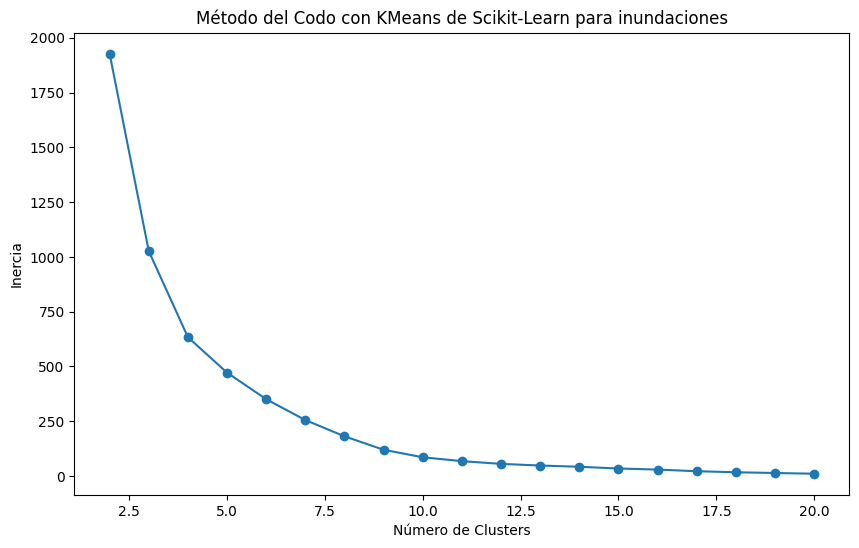

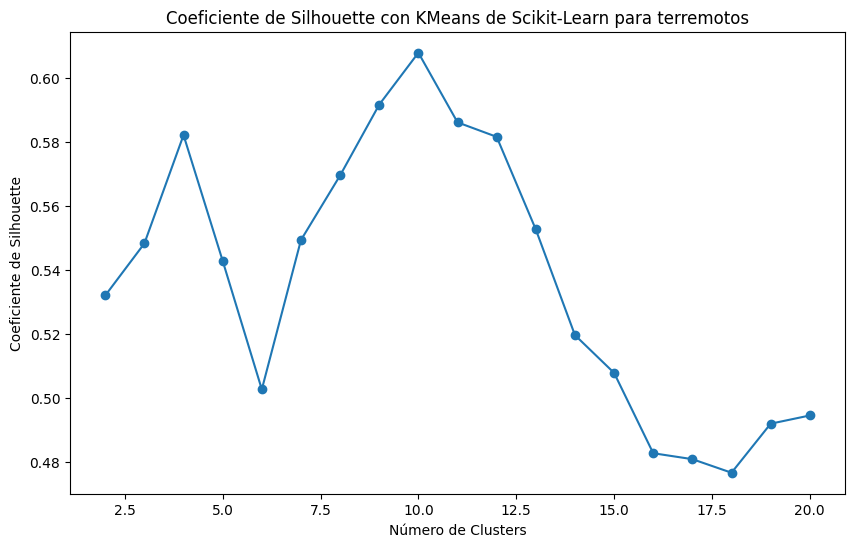

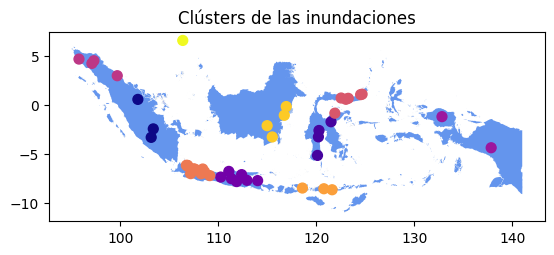

In [ ]:
"""Inundaciones"""
X_ind=np.array([(long_ind[i],lat_ind[i]) for i in range(len(long_ind))])

# Rango de números de clusters a probar
num_clusters_range = range(2, 21)

# Lista para almacenar la menor inercia para cada número de clusters
l_inercias=[]
l_silhouette=[]

# Calcular la inercia para cada número de clusters
for k in num_clusters_range:
    # Ejecutar KMeans con diferentes inicializaciones y escoger el mejor resultado
    model = KMeans(n_clusters=k,n_init=10, random_state=0)
    model.fit(X_ind)
    l_inercias.append(model.inertia_)
    silhouette = metrics.silhouette_score(X_ind, model.labels_)
    l_silhouette.append(silhouette)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, l_inercias, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo con KMeans de Scikit-Learn para inundaciones')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, l_silhouette, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette con KMeans de Scikit-Learn para terremotos')
plt.show()

n_cl_ind = 10

# Entrenar el modelo k-means con 10 clústeres
kmeans = KMeans(n_clusters=n_cl_ind,n_init=10)
kmeans.fit(X_ind)

# Obtener las etiquetas de los puntos
y_kmeans = kmeans.predict(X_ind)


fig, ax = plt.subplots()

df_plot.plot(ax=ax, color='cornflowerblue')

# Visualizar los datos coloreados por las etiquetas
plt.scatter(X_ind[:, 0], X_ind[:, 1], c=y_kmeans, s=50, cmap='plasma')  # Los puntos se representan por colores

# Obtener los centros de los clústeres
centros_inundaciones = kmeans.cluster_centers_

labels_ind = kmeans.labels_

# Visualizar los centros de los clústeres
#plt.scatter(centros_inundaciones[:,0], centros_inundaciones[:,1], c='black', s=200)

plt.title('Clústers de las inundaciones')

plt.show()

##Análisis por clúster:
Ahora, dadas las zonas en las que se reparten los terremotos e inundaciones, vamos a hacer un análisis de cada zona para cada desastre. Este análisis consistirá en ver la frecuencia por años de desastres en cada zona, y la evolución histórica de las magnitudes de los desastres en cada zona.

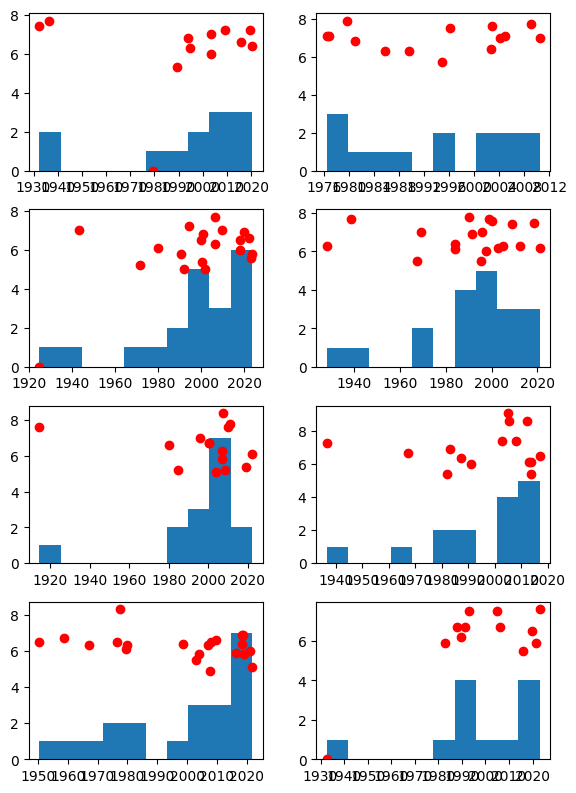

In [ ]:
"""Terremotos"""
mag_terr=list(eq_ind['Magnitude'])
date_terr=list(eq_ind['Fecha'])

fig, axes = plt.subplots(4,2,figsize=(6,8))

for i in range(n_cl_terr):
  magnitudes = []
  fechas = []
  for k in range(len(mag_terr)):
    if labels_terr[k]==i:
      magnitudes.append(mag_terr[k])
      fechas.append(date_terr[k])
  axes[i%4,i//4].hist(fechas)
  axes[i%4,i//4].scatter(fechas,magnitudes,color='r')

plt.tight_layout()
plt.show()


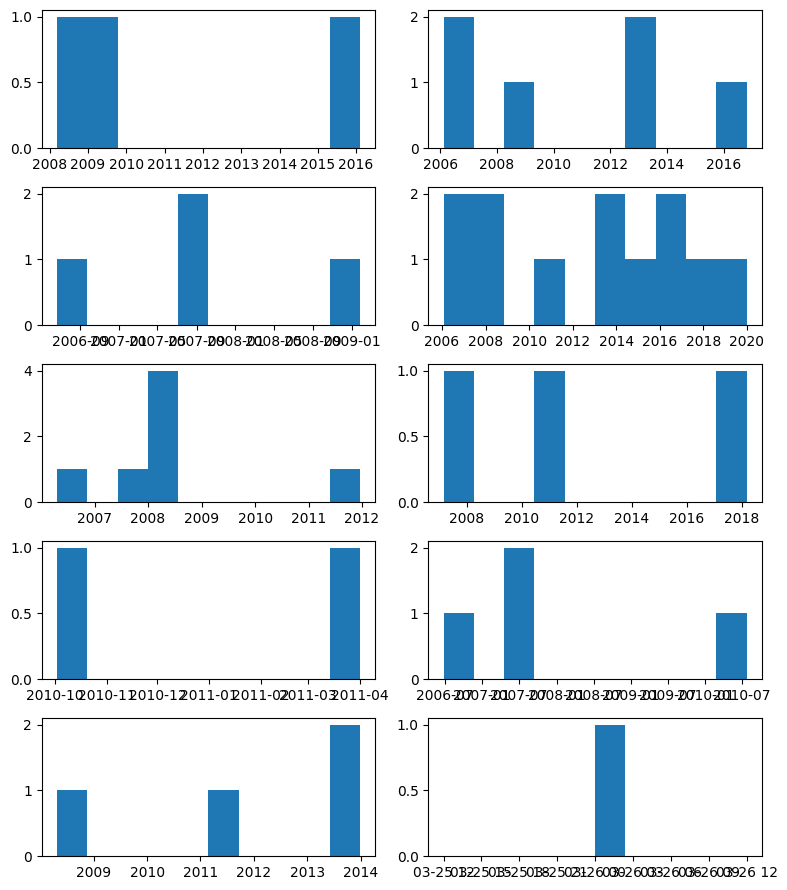

In [ ]:
"""Inundaciones"""
date_fd=list(fd_ind['Fecha'])

fig, axes = plt.subplots(5,2,figsize=(8,9))

for i in range(n_cl_ind):
  magnitudes = []
  fechas = []
  for k in range(len(date_fd)):
    if labels_ind[k]==i:
      fechas.append(date_fd[k])
  axes[i%5,i//5].hist(fechas)

plt.tight_layout()
plt.show()

A continuación, veamos la correlación entre variables:

<Axes: >

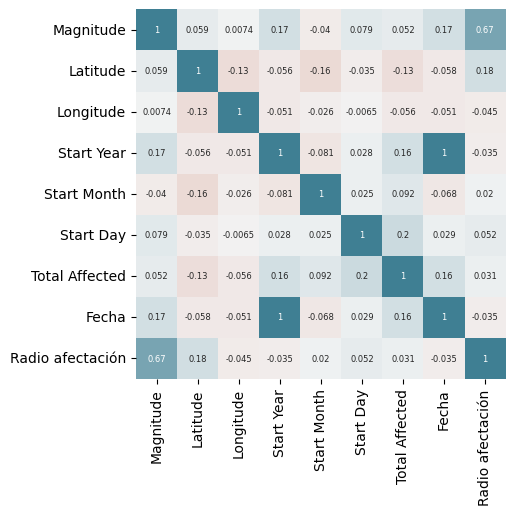

In [ ]:
import seaborn as sns
sns.heatmap(eq_ind.corr(),

    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True)

<Axes: >

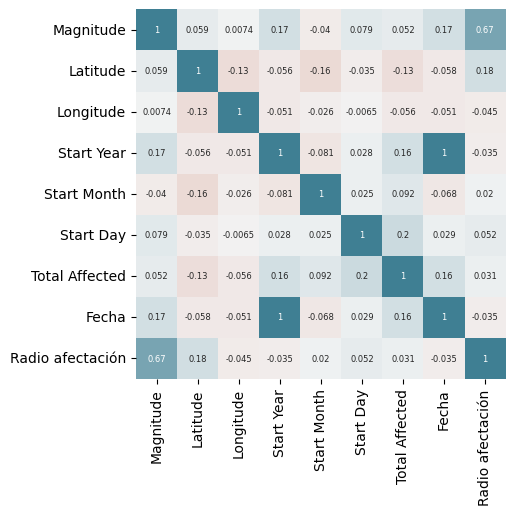

In [ ]:
sns.heatmap(eq_ind.corr(),

    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True)

In [ ]:
eq_ind.describe()

,Magnitude,Latitude,Longitude,Start Year,Start Month,Start Day,Total Affected,Fecha,Radio afectación
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128,128.00000
mean,6.429688,-3.192763,115.505320,1994.875000,6.710938,15.796875,1.132316e+05,1995-05-23 11:26:15,144.53125
min,0.000000,-11.164000,93.063000,1914.000000,1.000000,1.000000,7.000000e+00,1914-06-26 00:00:00,10.00000
25%,6.000000,-7.687500,104.668750,1984.000000,4.000000,9.000000,1.090000e+03,1984-06-30 00:00:00,100.00000
50%,6.500000,-3.594000,116.548500,2001.500000,7.000000,16.000000,5.500000e+03,2002-01-20 12:00:00,100.00000
75%,7.100000,-0.138000,125.267000,2009.250000,10.000000,23.000000,1.696500e+04,2010-01-02 00:00:00,250.00000
max,9.100000,8.800000,140.091000,2023.000000,12.000000,30.000000,3.177923e+06,2023-06-30 00:00:00,700.00000
std,1.301868,4.528419,12.697877,23.360577,3.587275,8.629157,4.428565e+05,NaN,143.05915


##Modelo predictivo
Como la demanda va a ser proporcional a la cantidad de gente afectada por el desastre, vamos a hacer un  modelo para tratar de predecir la cantidad de gente afectada en función de la fecha, localización y magnitud del desastre. Para ello usaremos un modelo de Aprendizaje supervisado que tenga como variables predictoras las ya mencionadas fecha, localización por zona, latitud y longitud, y magnitud del desastre, y como variable objetivo el número total de afectados por el desastre.

Comenzamos viendo si es necesaria una transformación de la variable objetivo a través de una transformación de Box-Cox

In [ ]:
from scipy.stats import boxcox

df_boxcox = eq_ind[['Total Affected']]

# BoxCox transformation
df_boxcox_vals, fitted_lambda = boxcox(df_boxcox['Total Affected'])
print(fitted_lambda)

-0.002773532397905747


In [ ]:
df_boxcox = fd_ind[['Total Affected']]

# BoxCox transformation
df_boxcox_vals, fitted_lambda = boxcox(df_boxcox['Total Affected'])
print(fitted_lambda)

0.05943559393716212


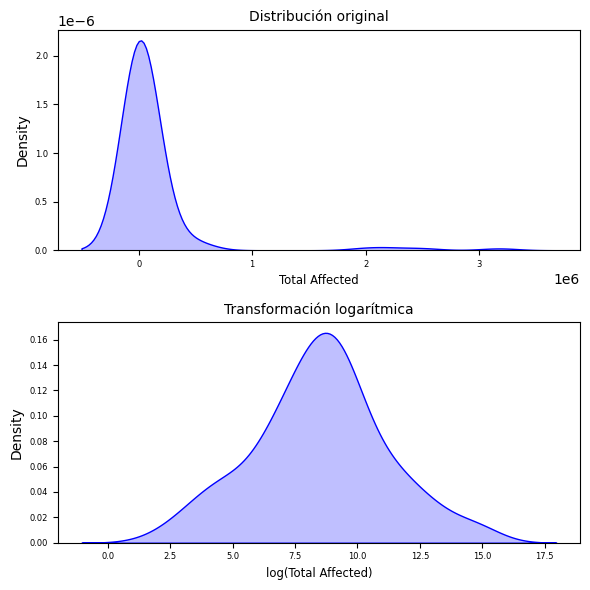

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.kdeplot(
    eq_ind['Total Affected'],
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Total Affected', fontsize='small')
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(eq_ind['Total Affected']),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación logarítmica", fontsize = 'medium')
axes[1].set_xlabel('log(Total Affected)', fontsize='small')
axes[1].tick_params(labelsize = 6)

fig.tight_layout()

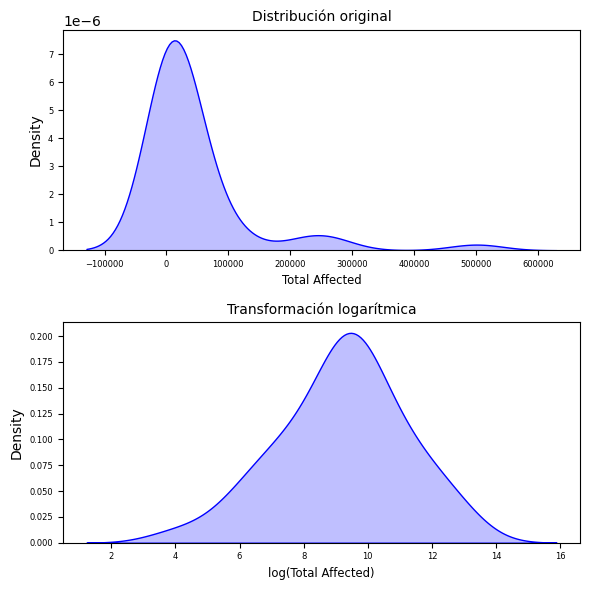

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.kdeplot(
    fd_ind['Total Affected'],
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Total Affected', fontsize='small')
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(fd_ind['Total Affected']),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación logarítmica", fontsize = 'medium')
axes[1].set_xlabel('log(Total Affected)', fontsize='small')
axes[1].tick_params(labelsize = 6)

fig.tight_layout()

Construyamos ahora los diferentes modelos. Para ello, usaremos la librería sklearn, y en ella modelos de KNN, regresiones lineales y diferentes modelos de ensamblado, y los compararemos usando el MSE:

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from itertools import product
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

"""Terremotos"""
explicativas = eq_ind[['Latitude', 'Longitude', 'Start Year', 'Magnitude']]
explicativas['Label']=labels_terr
target = np.log(eq_ind['Total Affected']+1)

# Dividir en train-test
X_train, X_test, y_train, y_test = train_test_split(explicativas,
                                                    target,
                                                    train_size   = 0.9,
                                                    random_state = 0,
                                                    shuffle      = True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 30, 30, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")


from sklearn.linear_model import Ridge
pipe = Pipeline([('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

from sklearn.linear_model import Lasso
pipe = Pipeline([('modelo', Lasso())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")


from sklearn.ensemble import RandomForestRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 20, 50, 100],
    'modelo__max_features': [2, 3, 5, 1.0],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")


from sklearn.ensemble import GradientBoostingRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 20, 50, 100],
    'modelo__max_features': [2, 3, 5, 1.0],
    'modelo__max_depth'   : [1,2,3,4]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

modelo_terremotos=modelo_final

   param_modelo__n_neighbors  mean_test_score  std_test_score  \
13                        25        -2.657337        0.216833   
9                         24        -2.659935        0.218768   
19                        26        -2.660365        0.216177   
3                         27        -2.662875        0.208125   
5                         28        -2.665545        0.204930   

    mean_train_score  std_train_score  
13         -2.559819         0.041523  
9          -2.556909         0.045157  
19         -2.560933         0.040279  
3          -2.561643         0.041756  
5          -2.566995         0.044764  
El error (rmse) de test es: 25076.63284296207
   param_modelo__alpha  mean_test_score  std_test_score  mean_train_score  \
16          375.967497        -2.522314        0.388639         -2.433975   
3          2171.067603        -2.527799        0.376017         -2.472528   
1            56.690073        -2.528753        0.398340         -2.416150   
2            35

In [ ]:
"""Inundaciones"""
explicativas = fd_ind[['Latitude', 'Longitude', 'Start Year', 'Magnitude']]
explicativas['Label']=labels_ind
target = np.log(fd_ind['Total Affected']+1)

# Dividir en train-test
X_train, X_test, y_train, y_test = train_test_split(explicativas,
                                                    target,
                                                    train_size   = 0.9,
                                                    random_state = 0,
                                                    shuffle      = True)

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 30, 30, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")


from sklearn.linear_model import Ridge
pipe = Pipeline([('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

from sklearn.linear_model import Lasso
pipe = Pipeline([('modelo', Lasso())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

modelo_inundaciones=modelo_final


from sklearn.ensemble import RandomForestRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 20, 50, 100],
    'modelo__max_features': [2, 3, 5, 1.0],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")


from sklearn.ensemble import GradientBoostingRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 20, 50, 100],
    'modelo__max_features': [2, 3, 5, 1.0],
    'modelo__max_depth'   : [1,2,3,4]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True,
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
print(resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(5))

modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = np.exp(y_test),
            y_pred  = np.exp(predicciones),
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

   param_modelo__n_neighbors  mean_test_score  std_test_score  \
1                         30        -2.046333        0.439515   
5                         28        -2.051575        0.434570   
19                        26        -2.055026        0.450645   
13                        25        -2.055301        0.460875   
14                        17        -2.055767        0.440018   

    mean_train_score  std_train_score  
1          -2.055434         0.110701  
5          -2.053416         0.110451  
19         -2.062719         0.112440  
13         -2.065190         0.110378  
14         -2.050629         0.107753  
El error (rmse) de test es: 6848.926689047258
   param_modelo__alpha  mean_test_score  std_test_score  mean_train_score  \
14        63037.531531        -2.082638        0.552441         -2.016661   
17        22841.122073        -2.085404        0.552557         -2.013707   
8          4981.897519        -2.100220        0.552067         -2.003085   
7          4337

#Generación de escenarios
Comenzamos con la generación de escenarios. Creamos un modelo de regresión logística, que, entrenado con desastres ocurridos y no ocurridos (que habrá que simular), nos devuelve la probabilidad de que nuevos desastres ocurran
La generación de simulaciones y probabilidades se hará por zonas, o clústers

In [ ]:
from sklearn.linear_model import LogisticRegression

nuevos_datos=eq_ind[['Latitude', 'Longitude', 'Start Year', 'Magnitude']]
nuevos_datos['Cluster']=labels_terr
nuevos_datos['Ocurrió']=np.ones(len(nuevos_datos))
seed=np.random.seed(0)

terremotos={}
lista_terremotos=[]
lista_probabilidades=[]

for cluster in range(len(centros_terremotos)):
    datos=nuevos_datos[nuevos_datos['Cluster']==cluster]
    minimos=np.array([min(datos[i]) for i in ['Latitude', 'Longitude', 'Start Year', 'Magnitude','Cluster','Ocurrió']])
    maximos=np.array([max(datos[i]) for i in ['Latitude', 'Longitude', 'Start Year', 'Magnitude','Cluster','Ocurrió']])
    len_datos=len(datos)
    for _ in range(len_datos):
        fila=minimos+(maximos-minimos)*np.random.rand(6)
        fila[2]=int(fila[2])
        fila[5]=0.0
        datos.loc[len(datos)] = fila
    #print(f'Inic: {len_datos}, fin: {len(datos)}')

    X=datos.drop(columns=['Cluster','Ocurrió'])
    y=datos['Ocurrió']

    model = LogisticRegression()
    model.fit(X, y)

    magnitudes = minimos[3]+(maximos[3]-minimos[3])*np.random.rand(6)

    posibles_terremotos=pd.DataFrame({
                                        'Latitude': np.ones(6)*centros_terremotos[cluster][1],
                                        'Longitude': np.ones(6)*centros_terremotos[cluster][0],
                                        'Start Year': np.ones(6)*2024,
                                        'Magnitude': magnitudes
                                    })

    probabilidades = model.predict_proba(posibles_terremotos)

    terremotos[cluster] = {}

    for i in range(6):
        terremotos[cluster][round(magnitudes[i],1)] = round(probabilidades[i,1],3)
        lista_terremotos.append((round(magnitudes[i],1),round(probabilidades[i,1],3),cluster))
        lista_probabilidades.append((round(probabilidades[i,1],3),round(magnitudes[i],1),'t',cluster))





C:\Users\Miguel\AppData\Local\Temp\ipykernel_14848\4223154197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevos_datos['Cluster']=labels_terr
C:\Users\Miguel\AppData\Local\Temp\ipykernel_14848\4223154197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevos_datos['Ocurrió']=np.ones(len(nuevos_datos))
C:\Users\Miguel\AppData\Local\Temp\ipykernel_14848\4223154197.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [ ]:
terremotos

{0: {6.6: 0.527, 7.9: 0.516, 5.9: 0.534, 8.1: 0.514, 6.5: 0.528, 6.1: 0.532},
 1: {6.1: 0.682, 1.7: 0.177, 2.7: 0.26, 7.1: 0.787, 5.4: 0.599, 0.2: 0.09},
 2: {5.4: 0.621, 5.1: 0.632, 7.4: 0.553, 4.9: 0.637, 7.5: 0.548},
 3: {7.1: 0.725, 5.2: 0.578, 6.5: 0.682, 5.3: 0.592, 5.9: 0.639},
 4: {2.9: 0.542, 6.9: 0.784, 7.5: 0.809, 4.2: 0.629, 2.1: 0.483, 4.6: 0.652},
 5: {5.9: 0.87, 6.3: 0.879, 7.1: 0.899, 5.6: 0.862, 6.9: 0.895, 6.6: 0.888},
 6: {5.8: 0.702, 7.1: 0.878, 0.2: 0.024, 6.9: 0.855, 3.0: 0.195, 6.8: 0.841},
 7: {6.5: 0.473, 7.1: 0.476, 6.3: 0.472, 7.6: 0.479, 5.9: 0.47, 6.2: 0.471}}

In [ ]:
nuevos_datos=fd_ind[['Latitude', 'Longitude', 'Start Year', 'Magnitude']]
nuevos_datos['Cluster']=labels_ind
nuevos_datos['Ocurrió']=np.ones(len(nuevos_datos))
seed=np.random.seed(0)

inundaciones={}

lista_inundaciones=[]

for cluster in range(len(centros_inundaciones)):
    datos=nuevos_datos[nuevos_datos['Cluster']==cluster]
    minimos=np.array([min(datos[i]) for i in ['Latitude', 'Longitude', 'Start Year', 'Magnitude','Cluster','Ocurrió']])
    maximos=np.array([max(datos[i]) for i in ['Latitude', 'Longitude', 'Start Year', 'Magnitude','Cluster','Ocurrió']])
    len_datos=len(datos)
    for _ in range(len_datos):
        fila=minimos+(maximos-minimos)*np.random.rand(6)
        fila[2]=int(fila[2])
        fila[5]=0.0
        datos.loc[len(datos)] = fila
    #print(f'Inic: {len_datos}, fin: {len(datos)}')

    X=datos.drop(columns=['Cluster','Ocurrió'])
    y=datos['Ocurrió']

    model = LogisticRegression()
    model.fit(X, y)

    magnitudes = minimos[3]+(maximos[3]-minimos[3])*np.random.rand(6)

    posibles_inundaciones=pd.DataFrame({
                                        'Latitude': np.ones(6)*centros_inundaciones[cluster][1],
                                        'Longitude': np.ones(6)*centros_inundaciones[cluster][0],
                                        'Start Year': np.ones(6)*2024,
                                        'Magnitude': magnitudes
                                    })

    probabilidades = model.predict_proba(posibles_inundaciones)

    inundaciones[cluster] = {}

    for i in range(6):
        inundaciones[cluster][round(magnitudes[i],1)] = round(probabilidades[i,1],3)
        lista_inundaciones.append((round(magnitudes[i],1),round(probabilidades[i,1],3),cluster))
        lista_probabilidades.append((round(probabilidades[i,1],3),round(magnitudes[i],1),'i',cluster))

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14848\2518514373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevos_datos['Cluster']=labels_ind
C:\Users\Miguel\AppData\Local\Temp\ipykernel_14848\2518514373.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuevos_datos['Ocurrió']=np.ones(len(nuevos_datos))
C:\Users\Miguel\AppData\Local\Temp\ipykernel_14848\2518514373.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

In [ ]:
inundaciones

{0: {71380.8: 0.21,
  44346.2: 0.376,
  54117.1: 0.31,
  3228.6: 0.678,
  20937.2: 0.551,
  9117.1: 0.637},
 1: {45195.6: 0.477,
  58409.0: 0.455,
  16879.9: 0.523,
  35938.1: 0.492,
  36862.8: 0.49,
  35710.8: 0.492},
 2: {9254.0: 0.529,
  15327.7: 0.537,
  25463.1: 0.552,
  26243.1: 0.553,
  25625.8: 0.552,
  28568.3: 0.557},
 3: {8348.3: 0.625,
  31502.7: 0.365,
  29259.7: 0.389,
  12058.8: 0.585,
  47355.3: 0.216,
  31121.9: 0.369},
 4: {1006.9: 0.269,
  7537.6: 0.807,
  5410.0: 0.654,
  12082.3: 0.958,
  6554.4: 0.743,
  3116.3: 0.446},
 5: {58517.8: 0.327,
  8730.6: 0.639,
  35404.4: 0.47,
  9700.3: 0.633,
  48711.7: 0.386,
  27311.1: 0.522},
 6: {19200.0: 0.5},
 7: {22485.3: 0.36,
  19575.7: 0.399,
  16122.1: 0.448,
  21112.3: 0.379,
  9216.7: 0.546,
  20593.6: 0.386},
 8: {19040.8: 0.404,
  11073.9: 0.391,
  78808.1: 0.502,
  6841.5: 0.385,
  83341.4: 0.509,
  20497.8: 0.406},
 9: {108300.4: 0.422,
  202889.2: 0.551,
  88942.9: 0.397,
  188632.5: 0.532,
  201355.3: 0.549,
  201

Nos quedamos de cada zona y cada tipo de desastre con el más probable y el más destructivo:

In [ ]:
# Nos vamos a quedar con el desastre de cada tipo y en cada cúster de más magnitud y con más probabilidad
posibles_desastres=[]

for c in terremotos:
    mas_probable = max(terremotos[c], key=lambda k: terremotos[c][k])
    posibles_desastres.append([terremotos[c][mas_probable],mas_probable,c,'terremoto'])
    mas_magnitud=max(terremotos[c].keys())
    posibles_desastres.append([terremotos[c][mas_magnitud],mas_magnitud,c,'terremoto'])

for c in inundaciones:
    mas_probable = max(inundaciones[c], key=lambda k: inundaciones[c][k])
    posibles_desastres.append([inundaciones[c][mas_probable],np.sqrt(mas_probable/np.pi),c,'inundación'])
    mas_magnitud=max(inundaciones[c].keys())
    posibles_desastres.append([inundaciones[c][mas_magnitud],np.sqrt(mas_magnitud/np.pi),c,'inundación'])

(posibles_desastres)

[[0.534, 5.9, 0, 'terremoto'],
 [0.514, 8.1, 0, 'terremoto'],
 [0.787, 7.1, 1, 'terremoto'],
 [0.787, 7.1, 1, 'terremoto'],
 [0.637, 4.9, 2, 'terremoto'],
 [0.548, 7.5, 2, 'terremoto'],
 [0.725, 7.1, 3, 'terremoto'],
 [0.725, 7.1, 3, 'terremoto'],
 [0.809, 7.5, 4, 'terremoto'],
 [0.809, 7.5, 4, 'terremoto'],
 [0.899, 7.1, 5, 'terremoto'],
 [0.899, 7.1, 5, 'terremoto'],
 [0.878, 7.1, 6, 'terremoto'],
 [0.878, 7.1, 6, 'terremoto'],
 [0.479, 7.6, 7, 'terremoto'],
 [0.479, 7.6, 7, 'terremoto'],
 [0.678, 32.057687042782526, 0, 'inundación'],
 [0.21, 150.73557749817368, 0, 'inundación'],
 [0.523, 73.30101669004168, 1, 'inundación'],
 [0.455, 136.3530789608692, 1, 'inundación'],
 [0.557, 95.36022400070371, 2, 'inundación'],
 [0.557, 95.36022400070371, 2, 'inundación'],
 [0.625, 51.54945608663722, 3, 'inundación'],
 [0.216, 122.77483517887232, 3, 'inundación'],
 [0.958, 62.01544596177967, 4, 'inundación'],
 [0.958, 62.01544596177967, 4, 'inundación'],
 [0.639, 52.71656563468643, 5, 'inundación

Generamos los escenarios introduciendo desastres en función de sus probabilidades:

In [ ]:
num_escenarios=5
escenarios={}
np.random.seed(1)


for i in range(1,num_escenarios+1):
    # Comenzamos definiendo escenarios vacíos
    escenarios[i]=[[],1]

    for j in range(len(centros_terremotos)):
        r = 5*np.random.rand()
        if r<posibles_desastres[2*j][0]:
            escenarios[i][0].append(posibles_desastres[2*j])
            escenarios[i][1]*=posibles_desastres[2*j][0]
        elif r<posibles_desastres[2*j][0]+posibles_desastres[2*j+1][0]:
            escenarios[i][0].append(posibles_desastres[2*j+1])
            escenarios[i][1]*=posibles_desastres[2*j+1][0]

    for j in range(len(centros_inundaciones)):
        r = 4*np.random.rand()
        if r<posibles_desastres[2*len(centros_terremotos)+2*j][0]:
            escenarios[i][0].append(posibles_desastres[2*len(centros_terremotos)+2*j])
            escenarios[i][1]*=posibles_desastres[2*len(centros_terremotos)+2*j][0]
        elif r<posibles_desastres[2*len(centros_terremotos)+2*j][0]+posibles_desastres[2*len(centros_terremotos)+2*j+1][0]:
            escenarios[i][0].append(posibles_desastres[2*len(centros_terremotos)+2*j+1])
            escenarios[i][1]*=posibles_desastres[2*len(centros_terremotos)+2*j+1][0]

suma_probabilidades=0
for esc in escenarios:
    escenarios[esc][1]=round(escenarios[esc][1],3)
    suma_probabilidades+=round(escenarios[esc][1],3)
print(suma_probabilidades)

escenarios

0.7650000000000001


{1: [[[0.637, 4.9, 2, 'terremoto'],
   [0.809, 7.5, 4, 'terremoto'],
   [0.899, 7.1, 5, 'terremoto'],
   [0.878, 7.1, 6, 'terremoto'],
   [0.958, 62.01544596177967, 4, 'inundación'],
   [0.5, 78.17640190446718, 6, 'inundación']],
  0.195],
 2: [[[0.514, 8.1, 0, 'terremoto'],
   [0.787, 7.1, 1, 'terremoto'],
   [0.809, 7.5, 4, 'terremoto'],
   [0.678, 32.057687042782526, 0, 'inundación'],
   [0.523, 73.30101669004168, 1, 'inundación'],
   [0.557, 95.36022400070371, 2, 'inundación'],
   [0.958, 62.01544596177967, 4, 'inundación']],
  0.062],
 3: [[[0.637, 4.9, 2, 'terremoto'],
   [0.878, 7.1, 6, 'terremoto'],
   [0.678, 32.057687042782526, 0, 'inundación'],
   [0.958, 62.01544596177967, 4, 'inundación'],
   [0.639, 52.71656563468643, 5, 'inundación'],
   [0.5, 78.17640190446718, 6, 'inundación'],
   [0.509, 162.8753865640778, 8, 'inundación'],
   [0.551, 254.1291761288348, 9, 'inundación']],
  0.033],
 4: [[[0.787, 7.1, 1, 'terremoto'],
   [0.725, 7.1, 3, 'terremoto'],
   [0.878, 7.1, 6,

Código auxiliar para generar el informe en látex:

In [ ]:
for esc in escenarios:
    escenarios[esc][1]/=round(suma_probabilidades,3)
    for d in escenarios[esc][0]:
        if d[3]=='terremoto':
            print(f'\item Terremoto en la zona {int(d[2])} de magnitud {d[1]}')
        else:
            print(f'\item Inundación en la zona {int(d[2])} de radio {round(d[1])} km')

\item Terremoto en la zona 2 de magnitud 4.9
\item Terremoto en la zona 4 de magnitud 7.5
\item Terremoto en la zona 5 de magnitud 7.1
\item Terremoto en la zona 6 de magnitud 7.1
\item Inundación en la zona 4 de radio 62 km
\item Inundación en la zona 6 de radio 78 km
\item Terremoto en la zona 0 de magnitud 8.1
\item Terremoto en la zona 1 de magnitud 7.1
\item Terremoto en la zona 4 de magnitud 7.5
\item Inundación en la zona 0 de radio 32 km
\item Inundación en la zona 1 de radio 73 km
\item Inundación en la zona 2 de radio 95 km
\item Inundación en la zona 4 de radio 62 km
\item Terremoto en la zona 2 de magnitud 4.9
\item Terremoto en la zona 6 de magnitud 7.1
\item Inundación en la zona 0 de radio 32 km
\item Inundación en la zona 4 de radio 62 km
\item Inundación en la zona 5 de radio 53 km
\item Inundación en la zona 6 de radio 78 km
\item Inundación en la zona 8 de radio 163 km
\item Inundación en la zona 9 de radio 254 km
\item Terremoto en la zona 1 de magnitud 7.1
\item Te

Visualizamos el resultado:

In [ ]:
for esc in escenarios:
    for d in escenarios[esc][0]:
        if d[3]=='terremoto':
            d.append(rad(d[1]))
            afectados=np.exp(modelo_terremotos.predict(np.array([centros_terremotos[d[2]][1],centros_terremotos[d[2]][0],2024,d[1],d[2]]).reshape(1, -1))[0])
            d.append(round(afectados))
        else:
            d.append(d[1])
            afectados=np.exp(modelo_inundaciones.predict(np.array([centros_inundaciones[d[2]][1],centros_inundaciones[d[2]][0],2024,d[1]**2*np.pi,d[2]]).reshape(1, -1))[0])
            d.append(round(afectados))
    print(f'\n\nEscenario {esc}:\n')
    print(escenarios[esc])



Escenario 1:

[[[0.637, 4.9, 2, 'terremoto', 10, 9817], [0.809, 7.5, 4, 'terremoto', 250, 7510], [0.899, 7.1, 5, 'terremoto', 250, 7510], [0.878, 7.1, 6, 'terremoto', 250, 12420], [0.958, 62.01544596177967, 4, 'inundación', 62.01544596177967, 9668], [0.5, 78.17640190446718, 6, 'inundación', 78.17640190446718, 9668]], 0.2549019607843137]


Escenario 2:

[[[0.514, 8.1, 0, 'terremoto', 700, 7510], [0.787, 7.1, 1, 'terremoto', 250, 12420], [0.809, 7.5, 4, 'terremoto', 250, 7510], [0.678, 32.057687042782526, 0, 'inundación', 32.057687042782526, 9668], [0.523, 73.30101669004168, 1, 'inundación', 73.30101669004168, 9668], [0.557, 95.36022400070371, 2, 'inundación', 95.36022400070371, 9668], [0.958, 62.01544596177967, 4, 'inundación', 62.01544596177967, 9668, 62.01544596177967, 9668]], 0.08104575163398693]


Escenario 3:

[[[0.637, 4.9, 2, 'terremoto', 10, 9817, 10, 9817], [0.878, 7.1, 6, 'terremoto', 250, 12420, 250, 12420], [0.678, 32.057687042782526, 0, 'inundación', 32.057687042782526, 9

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X do

Introducimos la lista de ciudades del mapa y visualizamos:

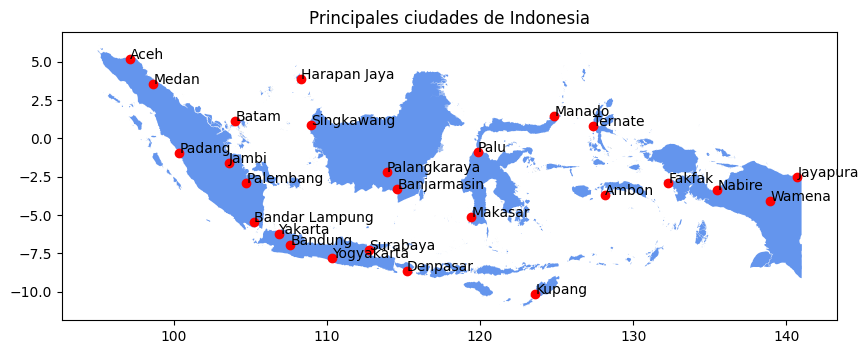

In [ ]:
ciudades=np.array([[-6.21462, 106.84513, 'Yakarta'],
                   [-7.24917, 112.75083, 'Surabaya'],
                   [3.58333, 98.66667,'Medan'],
                   [-6.92222, 107.60694,'Bandung'],
                   [-2.91673, 104.7458,'Palembang'],
                   [-5.14861, 119.43194,'Makasar'],
                   [1.14937, 104.02491,'Batam'],
                   [-0.94924, 100.35427,'Padang'],
                   [-5.42917, 105.26111,'Bandar Lampung'],
                   [-3.31987, 114.59075,'Banjarmasin'],
                   [-8.65, 115.21667,'Denpasar'],
                   [-1.6, 103.61667,'Jambi'],
                   [-7.80139, 110.36472,'Yogyakarta'],
                   [1.48218, 124.84892,'Manado'],
                   [-0.90833, 119.87083,'Palu'],
                   [-10.17083, 123.60694,'Kupang'],
                   [-3.69583, 128.18333,'Ambon'],
                   [5.1801, 97.1507,'Aceh'],
                   [0.79065, 127.38424,'Ternate'],
                   [0.90925, 108.98463,'Singkawang'],
                   [-2.20833, 113.91667,'Palangkaraya'],
                   [-2.92481, 132.29813,'Fakfak'],
                   [3.87472, 108.30306,'Harapan Jaya'],
                   [-3.35989, 135.50074,'Nabire'],
                   [-2.53371, 140.71813,'Jayapura'],
                   [-4.09512, 138.94492,'Wamena']])

X=list(ciudades[:,1].astype(float))
Y=list(ciudades[:,0].astype(float))
nombres=list(ciudades[:,2])

fig, ax = plt.subplots(figsize=(10,20))
df_plot.plot(ax=ax, color='cornflowerblue')
plt.scatter(X, Y, color="red")
for i, label in enumerate(nombres):
    plt.annotate(label, (X[i], Y[i]))
plt.title('Principales ciudades de Indonesia')
plt.show()

Calculamos, parta cada desastre, las ciudades que están dentro de su radio de afectación:

In [ ]:
import pyproj, sys
name_ellps = "WGS84"
geod = pyproj.Geod(ellps=name_ellps)


for esc in escenarios:
    for d in escenarios[esc][0]:
        posibilidades=[]
        if d[3]=='terremoto':
            lat=centros_terremotos[d[2]][1]
            lon=centros_terremotos[d[2]][0]
        else:
            lat=centros_inundaciones[d[2]][1]
            lon=centros_inundaciones[d[2]][0]
        for ciudad in ciudades:
            _,_,distancia=geod.inv(lon, lat, ciudad[1], ciudad[0])
            distancia=round(distancia/1000,2)
            if distancia<d[4]:
                posibilidades.append([ciudad,distancia])
        d.append(posibilidades)
        print(d[-3:])

[10, 9817, []]
[250, 7510, [[array(['0.79065', '127.38424', 'Ternate'], dtype='<U32'), 131.99]]]
[250, 7510, [[array(['-0.90833', '119.87083', 'Palu'], dtype='<U32'), 70.02]]]
[250, 12420, [[array(['-6.21462', '106.84513', 'Yakarta'], dtype='<U32'), 161.7], [array(['-6.92222', '107.60694', 'Bandung'], dtype='<U32'), 78.69]]]
[62.01544596177967, 9668, []]
[78.17640190446718, 9668, []]
[700, 7510, [[array(['3.58333', '98.66667', 'Medan'], dtype='<U32'), 281.4], [array(['5.1801', '97.1507', 'Aceh'], dtype='<U32'), 165.41]]]
[250, 12420, []]
[250, 7510, [[array(['0.79065', '127.38424', 'Ternate'], dtype='<U32'), 131.99]]]
[32.057687042782526, 9668, []]
[73.30101669004168, 9668, []]
[95.36022400070371, 9668, []]
[9668, [], []]
[9817, [], []]
[12420, [[array(['-6.21462', '106.84513', 'Yakarta'], dtype='<U32'), 161.7], [array(['-6.92222', '107.60694', 'Bandung'], dtype='<U32'), 78.69]], [[array(['-6.21462', '106.84513', 'Yakarta'], dtype='<U32'), 161.7], [array(['-6.92222', '107.60694', 'Band

Repartimos la demanda en función de la cercanía al epicentro del desastre:

In [ ]:
demandas=np.zeros((len(ciudades),num_escenarios))

for esc in escenarios:
    for d in escenarios[esc][0]:
        total=d[5]
        afectadas=d[-1]
        d_t=0
        for c in afectadas:
            d_t+=1/(c[1]+1)
        for c in afectadas:
            dem=round(total*(1/(c[1]+1))/d_t)
            for i in range(len(ciudades)):
                if c[0][0]==ciudades[i][0]:
                    demandas[i][esc-1]+=dem

print(demandas)

[[4083.    0. 4083. 4083.    0.]
 [   0.    0.    0.    0.    0.]
 [   0. 2785.    0.    0. 2785.]
 [8337.    0. 8337. 8337.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0. 7510. 7510.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0. 9668. 9668.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [7510.    0.    0.    0. 7510.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0. 4725.    0.    0. 4725.]
 [7510. 7510.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]]


Visualizamos los mapas con las demandas por países:

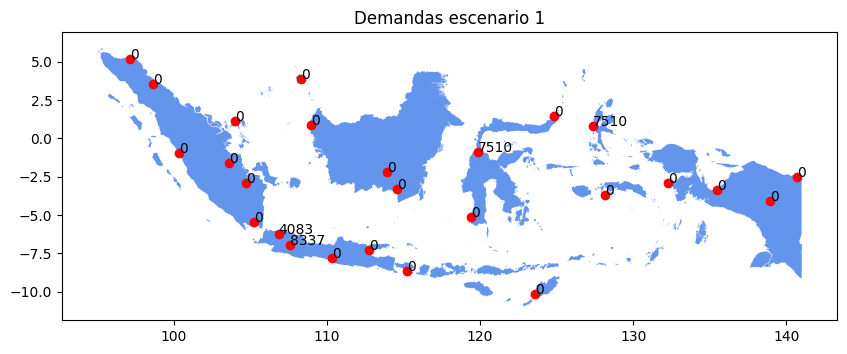

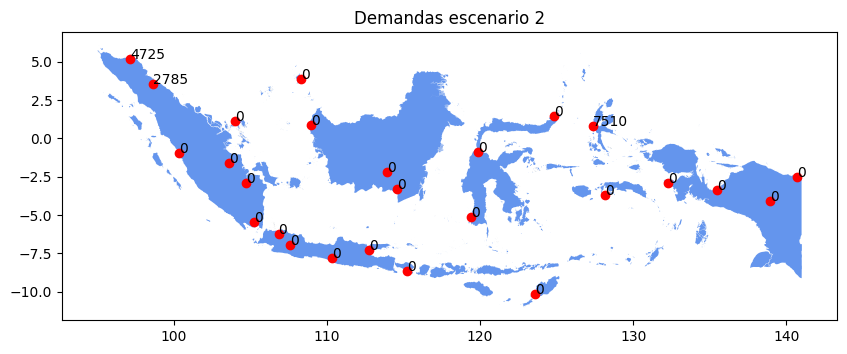

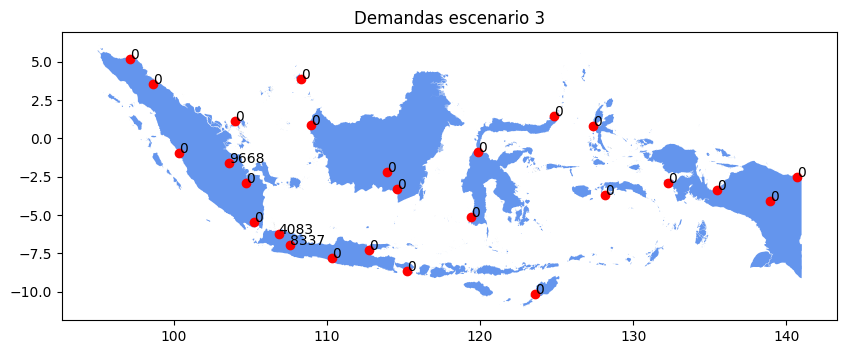

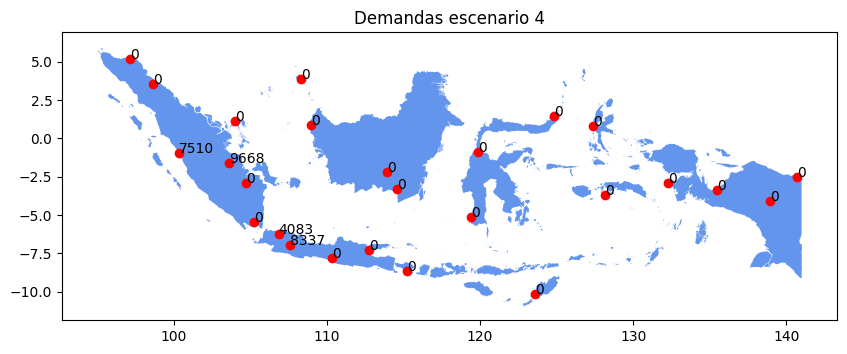

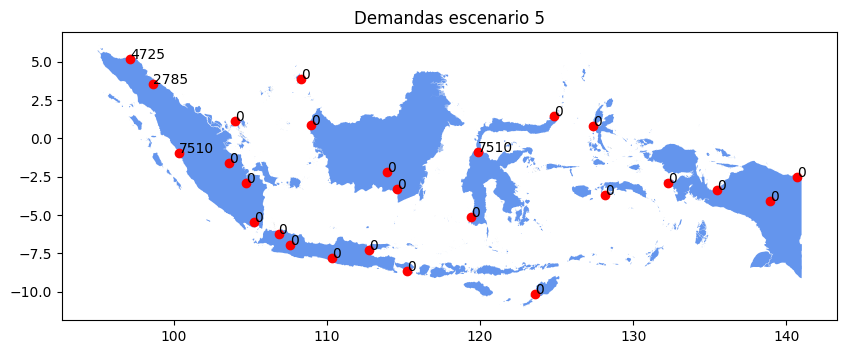

In [ ]:
X=list(ciudades[:,1].astype(float))
Y=list(ciudades[:,0].astype(float))

for e in range(num_escenarios):
    demanda=list(demandas[:,e])
    fig, ax = plt.subplots(figsize=(10,20))
    df_plot.plot(ax=ax, color='cornflowerblue')
    plt.scatter(X, Y, color="red")
    for i, label in enumerate(demanda):
        plt.annotate(int(label), (X[i], Y[i]))
    plt.title(f'Demandas escenario {e+1}')
    plt.show()

Función auxiliar para comprobar si un desastre afecta a una carretera, viendo si algún punto de la carretera está a una distancia del epicentro menor que su radio de afectación:

In [ ]:
def afecta_carretera(epicentro,radio,ciudad1,ciudad2):
    _,_,distancia1=geod.inv(epicentro[0], epicentro[1], ciudad1[1], ciudad1[0])
    if distancia1<radio:
        return True
    _,_,distancia2=geod.inv(epicentro[0], epicentro[1], ciudad2[1], ciudad2[0])
    if distancia2<radio:
        return True
    t=((epicentro[1]-ciudad1[0])*(ciudad2[0]-ciudad1[0])+(epicentro[0]-ciudad1[1])*(ciudad2[1]-ciudad1[1]))/((ciudad2[0]-ciudad1[0])**2+(ciudad2[1]-ciudad1[1])**2)
    if 0<t and t<1:
        x1=ciudad1[0]+t*(ciudad2[0]-ciudad1[0])
        x2=ciudad1[1]+t*(ciudad2[1]-ciudad1[1])
        _,_,distancia=geod.inv(epicentro[0], epicentro[1], x2, x1)
        if distancia<radio:
            return True
    return False

Calculamos las carreteras afectadas por cada desastre:

In [ ]:
carreteras=np.zeros((num_escenarios,2,len(ciudades),len(ciudades))) # si es 0 no está afectado, y si es 1 sí

posciudades=ciudades[:,:2].astype(float)

for esc in range(num_escenarios):
    for desastre in escenarios[esc+1][0]:
        # Primero procedemos con los terremotos:
        if desastre[3]=='terremoto':
            epicentro=centros_terremotos[desastre[2]]
            for i in range(len(ciudades)):
                for j in range(i+1,len(ciudades)):
                    if carreteras[esc][0][i][j]==0:
                        if afecta_carretera(epicentro,desastre[5],posciudades[i],posciudades[j]):
                            carreteras[esc][0][i][j]=1
        # A continuación las inundaciones:
        else:
            epicentro=centros_inundaciones[desastre[2]]
            for i in range(len(ciudades)):
                for j in range(i+1,len(ciudades)):
                    if carreteras[esc][1][i][j]==0:
                        if afecta_carretera(epicentro,desastre[5],posciudades[i],posciudades[j]):
                            carreteras[esc][1][i][j]=1

A continuación, verificamos qué ciudades están inicialmente disponibles para cada tipo de vehículo:

In [ ]:
from itertools import product
islas=[[17,2,7,6,11,4,8],[0,3,12,1,10],[15],[22],[19,20,9],[5,14,13],[18],[16],[21,23,25,24]]
interior=[11,4,3,20,25]

no_camiones=[]
for i in range(len(islas)):
    for j in range(i+1,len(islas)):
        no_camiones=no_camiones+list(product(islas[i],islas[j]))
print(len(no_camiones))

no_barcos=[]
for i in interior:
    no_barcos=no_barcos+list(product([i],list(range(len(ciudades)))))
print(len(no_barcos))

282
130


Finalmente, construimos la lista final de ciudades disponibles para cada vehículo en cada escenario:

In [ ]:
cortadas_camiones=np.zeros((num_escenarios,len(ciudades),len(ciudades))) # si es 0 no está afectado, y si es 1 sí

for esc in range(num_escenarios):
    for c1,c2 in no_camiones:
        cortadas_camiones[esc][c1][c2]=1
        cortadas_camiones[esc][c2][c1]=1
    for i in range(len(ciudades)):
        for j in range(i+1,len(ciudades)):
            if carreteras[esc][0][i][j]==1 or carreteras[esc][1][i][j]==1 or carreteras[esc][0][j][i]==1 or carreteras[esc][1][j][i]==1:
                cortadas_camiones[esc][i][j]=1
                cortadas_camiones[esc][j][i]=1


cortadas_barcos=np.zeros((num_escenarios,len(ciudades),len(ciudades))) # si es 0 no está afectado, y si es 1 sí

for esc in range(num_escenarios):
    for c1,c2 in no_camiones:
        cortadas_barcos[esc][c1][c2]=1
        cortadas_barcos[esc][c2][c1]=1
    for i in range(len(ciudades)):
        for j in range(i+1,len(ciudades)):
            if carreteras[esc][1][i][j]==1 or carreteras[esc][1][j][i]==1:
                cortadas_barcos[esc][i][j]=0
                cortadas_barcos[esc][j][i]=0


Código auxiliar para la generación del script de GAMS:

In [ ]:
# Código para generar el script de GAMS
with open('carreteras_cortadas.txt','w') as sal:
    for esc in range(num_escenarios):
        print(f"sets\ncortadas_camiones_esc_{esc+1}(i,j) la carretera ij esta cortada para los camiones en el escenario {esc+1}\ncortadas_barcos_esc_{esc+1}(i,j) la carretera ij esta cortada para los barcos en el escenario {esc+1}\n;\n")
        sal.write(f"sets\ncortadas_camiones_esc_{esc+1}(i,j) la carretera ij esta cortada para los camiones en el escenario {esc+1}\ncortadas_barcos_esc_{esc+1}(i,j) la carretera ij esta cortada para los barcos en el escenario {esc+1}\n;\n")
        print(f"cortadas_camiones_esc_{esc+1}(i,j)=no;\n")
        sal.write(f"cortadas_camiones_esc_{esc+1}(i,j)=no;\n")
        print(f"cortadas_barcos_esc_{esc+1}(i,j)=no;\n")
        sal.write(f"cortadas_barcos_esc_{esc+1}(i,j)=no;\n")
        for i in range(len(ciudades)):
            for j in range(len(ciudades)):
                if i!=j and cortadas_camiones[esc][i][j]==1:
                    print(f"cortadas_camiones_esc_{esc+1}('{i+1}','{j+1}')=yes;\n")
                    sal.write(f"cortadas_camiones_esc_{esc+1}('{i+1}','{j+1}')=yes;\n")
                if i!=j and cortadas_barcos[esc][i][j]==1:
                    print(f"cortadas_barcos_esc_{esc+1}('{i+1}','{j+1}')=yes;\n")
                    sal.write(f"cortadas_barcos_esc_{esc+1}('{i+1}','{j+1}')=yes;\n")
        print("\n")
        sal.write("\n")

sets
cortadas_camiones_esc_1(i,j) la carretera ij esta cortada para los camiones en el escenario 1
cortadas_barcos_esc_1(i,j) la carretera ij esta cortada para los barcos en el escenario 1
;

cortadas_camiones_esc_1(i,j)=no;

cortadas_barcos_esc_1(i,j)=no;

cortadas_camiones_esc_1('1','3')=yes;

cortadas_barcos_esc_1('1','3')=yes;

cortadas_camiones_esc_1('1','5')=yes;

cortadas_barcos_esc_1('1','5')=yes;

cortadas_camiones_esc_1('1','6')=yes;

cortadas_barcos_esc_1('1','6')=yes;

cortadas_camiones_esc_1('1','7')=yes;

cortadas_barcos_esc_1('1','7')=yes;

cortadas_camiones_esc_1('1','8')=yes;

cortadas_barcos_esc_1('1','8')=yes;

cortadas_camiones_esc_1('1','9')=yes;

cortadas_barcos_esc_1('1','9')=yes;

cortadas_camiones_esc_1('1','10')=yes;

cortadas_barcos_esc_1('1','10')=yes;

cortadas_camiones_esc_1('1','12')=yes;

cortadas_barcos_esc_1('1','12')=yes;

cortadas_camiones_esc_1('1','14')=yes;

cortadas_barcos_esc_1('1','14')=yes;

cortadas_camiones_esc_1('1','15')=yes;

cortadas_bar

Código auxiliar para la generación del script de GAMS:

In [ ]:
coste_construccion='/'
random.seed(1)
costes=[]
for i in range(len(ciudades)):
    x=random.randint(10,20)*1000
    coste_construccion=coste_construccion+f'{i+1} {x},'
    costes.append(x)
coste_construccion=coste_construccion[:-1]+'/'
print(coste_construccion)

/1 12000,2 19000,3 11000,4 14000,5 11000,6 17000,7 17000,8 17000,9 20000,10 16000,11 13000,12 11000,13 17000,14 10000,15 16000,16 16000,17 19000,18 10000,19 17000,20 14000,21 13000,22 19000,23 11000,24 15000,25 10000,26 10000/


Código auxiliar para la generación del script de GAMS:

In [ ]:
probabilidad_esc='/'
for i in escenarios.keys():
    probabilidad_esc=probabilidad_esc+f'{i} {escenarios[i][1]},'
probabilidad_esc=probabilidad_esc[:-1]+'/'
print(probabilidad_esc)

/1 0.2549019607843137,2 0.08104575163398693,3 0.043137254901960784,4 0.20130718954248367,5 0.4196078431372549/


Código auxiliar para la generación del script de GAMS:

In [ ]:
capacidades='/'
random.seed(2)
capac=[]
for i in range(len(ciudades)):
    x=random.randint(10,20)*1000
    capacidades=capacidades+f'{i+1} {x},'
    capac.append(x)
capacidades=capacidades[:-1]+'/'
print(capacidades)

/1 10000,2 11000,3 11000,4 15000,5 12000,6 20000,7 14000,8 14000,9 19000,10 13000,11 19000,12 10000,13 19000,14 20000,15 12000,16 16000,17 20000,18 16000,19 18000,20 15000,21 18000,22 17000,23 18000,24 14000,25 10000,26 10000/


Código auxiliar para la generación del script de GAMS:

In [ ]:
with open('distancias.txt', 'w') as sal:
    for i in range(len(ciudades)):
        ciudad1=posciudades[i]
        for j in range(len(ciudades)):
            ciudad2=posciudades[j]
            _,_,distancia=geod.inv(ciudad1[1], ciudad1[0], ciudad2[1], ciudad2[0])
            sal.write(f'l("{i+1}","{j+1}")={distancia};\n')
            print(f'l("{i+1}","{j+1}")={distancia};')

l("1","1")=0.0;
l("1","2")=662852.2992834507;
l("1","3")=1414302.336294092;
l("1","4")=114985.51901274675;
l("1","5")=432724.9627959829;
l("1","6")=1399246.1513209401;
l("1","7")=872531.7098408905;
l("1","8")=926662.6602467975;
l("1","9")=195753.2624265754;
l("1","10")=916873.0195297987;
l("1","11")=962503.2741761097;
l("1","12")=623607.3995978598;
l("1","13")=426637.6571261939;
l("1","14")=2174438.0748006664;
l("1","15")=1561164.795764706;
l("1","16")=1897608.7425049946;
l("1","17")=2382578.2010361347;
l("1","18")=1657808.4331523671;
l("1","19")=2410274.846419975;
l("1","20")=822843.0957159911;
l("1","21")=901316.7248776508;
l("1","22")=2847259.640088823;
l("1","23")=1127363.0737119338;
l("1","24")=3193940.9909975505;
l("1","25")=3780801.8702335437;
l("1","26")=3566091.0846770075;
l("2","1")=662852.2992834507;
l("2","2")=0.0;
l("2","3")=1970569.8957627804;
l("2","4")=569416.4188699706;
l("2","5")=1008482.4638713397;
l("2","6")=775003.1526402207;
l("2","7")=1342272.7523986627;
l("2","8

Código auxiliar para la generación del script de GAMS:

In [ ]:
with open('demandas.txt','w') as sal:
    for i in range(num_escenarios):
        dem=demandas[:,i]
        for j in range(len(ciudades)):
            sal.write(f'dem("{j+1}","{i+1}")={dem[j]};\n')
            print(f'dem("{j+1}","{i+1}")={dem[j]};')

dem("1","1")=4083.0;
dem("2","1")=0.0;
dem("3","1")=0.0;
dem("4","1")=8337.0;
dem("5","1")=0.0;
dem("6","1")=0.0;
dem("7","1")=0.0;
dem("8","1")=0.0;
dem("9","1")=0.0;
dem("10","1")=0.0;
dem("11","1")=0.0;
dem("12","1")=0.0;
dem("13","1")=0.0;
dem("14","1")=0.0;
dem("15","1")=7510.0;
dem("16","1")=0.0;
dem("17","1")=0.0;
dem("18","1")=0.0;
dem("19","1")=7510.0;
dem("20","1")=0.0;
dem("21","1")=0.0;
dem("22","1")=0.0;
dem("23","1")=0.0;
dem("24","1")=0.0;
dem("25","1")=0.0;
dem("26","1")=0.0;
dem("1","2")=0.0;
dem("2","2")=0.0;
dem("3","2")=2785.0;
dem("4","2")=0.0;
dem("5","2")=0.0;
dem("6","2")=0.0;
dem("7","2")=0.0;
dem("8","2")=0.0;
dem("9","2")=0.0;
dem("10","2")=0.0;
dem("11","2")=0.0;
dem("12","2")=0.0;
dem("13","2")=0.0;
dem("14","2")=0.0;
dem("15","2")=0.0;
dem("16","2")=0.0;
dem("17","2")=0.0;
dem("18","2")=4725.0;
dem("19","2")=7510.0;
dem("20","2")=0.0;
dem("21","2")=0.0;
dem("22","2")=0.0;
dem("23","2")=0.0;
dem("24","2")=0.0;
dem("25","2")=0.0;
dem("26","2")=0.0;
dem("1","

Código auxiliar para la generación del script de GAMS:

In [ ]:
random.seed(3)
camiones=[]
botes=[]
helic=[]
with open('vehiculos.txt','w') as sal:
    for j in range(len(ciudades)):
        c1=random.randint(3,7)
        camiones.append(c1)
        botes.append(c2)
        helic.append(c3)
        c2=random.randint(3,7)
        c3=random.randint(0,2)
        sal.write(f'm("{j+1}","1")={c1};')
        print(f'm("{j+1}","1")={c1};')
        sal.write(f'm("{j+1}","2")={c2};')
        print(f'm("{j+1}","2")={c2};')
        sal.write(f'm("{j+1}","3")={c3};')
        print(f'm("{j+1}","3")={c3};')

m("1","1")=4;
m("1","2")=7;
m("1","3")=2;
m("2","1")=4;
m("2","2")=5;
m("2","3")=2;
m("3","1")=6;
m("3","2")=7;
m("3","3")=0;
m("4","1")=7;
m("4","2")=3;
m("4","3")=1;
m("5","1")=5;
m("5","2")=7;
m("5","3")=0;
m("6","1")=4;
m("6","2")=6;
m("6","3")=2;
m("7","1")=7;
m("7","2")=6;
m("7","3")=1;
m("8","1")=4;
m("8","2")=4;
m("8","3")=2;
m("9","1")=4;
m("9","2")=7;
m("9","3")=1;
m("10","1")=3;
m("10","2")=3;
m("10","3")=0;
m("11","1")=7;
m("11","2")=3;
m("11","3")=1;
m("12","1")=3;
m("12","2")=5;
m("12","3")=1;
m("13","1")=7;
m("13","2")=6;
m("13","3")=2;
m("14","1")=6;
m("14","2")=6;
m("14","3")=2;
m("15","1")=7;
m("15","2")=6;
m("15","3")=0;
m("16","1")=5;
m("16","2")=3;
m("16","3")=0;
m("17","1")=4;
m("17","2")=6;
m("17","3")=0;
m("18","1")=5;
m("18","2")=6;
m("18","3")=2;
m("19","1")=5;
m("19","2")=6;
m("19","3")=2;
m("20","1")=6;
m("20","2")=7;
m("20","3")=1;
m("21","1")=7;
m("21","2")=7;
m("21","3")=1;
m("22","1")=7;
m("22","2")=4;
m("22","3")=1;
m("23","1")=3;
m("23","2")=5;
m("23",

#Solución del modelo:
Leemos la solución del modelo y graficamos

In [ ]:
import pandas as pd
sol=pd.read_excel('output.xlsx',sheet_name=0)
x=pd.read_excel('output.xlsx',sheet_name=1)
y=pd.read_excel('output.xlsx',sheet_name=2)
z=pd.read_excel('output.xlsx',sheet_name=3)
d=pd.read_excel('output.xlsx',sheet_name=4)
c=pd.read_excel('output.xlsx',sheet_name=5)


In [ ]:
Sol=sol.columns[0]
Sol

22792.824065633547

In [ ]:
X=list(x.columns.astype(int))
[ciudades[i-1][2] for i in X]

['Medan', 'Bandung', 'Manado']

In [ ]:
Y={}
for i in y.columns[2:]:
    for j in range(len(y)):
        if not np.isnan(y[i][j]):
            if int(y[i][j])>0:
                if int(i) not in Y:
                    Y[int(i)]={}
                Y[int(i)][(int(y['Unnamed: 0'][j]),int(y['Unnamed: 1'][j]))]=int(np.round(y[i][j]))
Y

{1: {(4, 1): 4083, (14, 15): 6000, (14, 19): 6000},
 2: {(3, 18): 4725, (14, 19): 9000},
 3: {(3, 18): 9668, (4, 1): 4083, (18, 12): 9668},
 4: {(3, 7): 9668, (3, 8): 7510, (4, 1): 4083, (7, 12): 9668},
 5: {(3, 7): 7510, (3, 18): 4725, (7, 8): 7510, (14, 15): 7510}}

In [ ]:
Z={}
for i in z.columns[3:]:
    for j in range(len(z)):
        if not np.isnan(z[i][j]):
            if int(i) not in Z:
                Z[int(i)]={}
            Z[int(i)][(int(z['Unnamed: 0'][j]),int(z['Unnamed: 1'][j]),int(z['Unnamed: 2'][j]))]=int(np.round(z[i][j]))
Z

{1: {(4, 1, 1): 1, (14, 15, 2): 2, (14, 19, 3): 2},
 2: {(3, 18, 2): 1, (14, 19, 3): 3},
 3: {(3, 18, 1): 1, (4, 1, 1): 1, (18, 12, 1): 1},
 4: {(3, 7, 1): 1, (3, 8, 2): 2, (4, 1, 1): 1, (7, 12, 1): 1},
 5: {(3, 7, 2): 2, (3, 18, 2): 1, (7, 8, 2): 2, (14, 15, 1): 1}}

In [ ]:
D={}
for i in d.columns[1:]:
    for j in range(len(d)):
        if not np.isnan(d[i][j]):
            if int(i) not in D:
                D[int(i)]={}
            D[int(i)][ciudades[int(d['Unnamed: 0'][j]-1)][2]]=int(np.round(d[i][j]))
    D[int(i)]['Total']=sum(D[int(i)].values())
D

{1: {'Yakarta': 4083,
  'Bandung': 8337,
  'Palu': 6000,
  'Ternate': 6000,
  'Total': 24420},
 2: {'Medan': 2785, 'Aceh': 4725, 'Ternate': 7510, 'Total': 15020},
 3: {'Yakarta': 4083, 'Bandung': 8337, 'Jambi': 9668, 'Total': 22088},
 4: {'Yakarta': 4083,
  'Bandung': 8337,
  'Padang': 7510,
  'Jambi': 9668,
  'Total': 29598},
 5: {'Medan': 2785,
  'Padang': 7510,
  'Palu': 7510,
  'Aceh': 4725,
  'Total': 22530}}

In [ ]:
C={}
for i in c.columns[2:]:
    for j in range(len(c)):
        if not np.isnan(c[i][j]):
            if int(i) not in C:
                C[int(i)]={}
            C[int(i)][(ciudades[int(c['Unnamed: 0'][j])-1][2],int(c['Unnamed: 1'][j]))]=int(np.round(c[i][j]))
C

{2: {('Manado', 3): 1}}

Código auxiliar para la generación del script de Latex:

In [ ]:
for i in range(len(ciudades)):
    print(f'{ciudades[i][2]} & {costes[i]} & {camiones[i]} & {botes[i]} & {helic[i]} & {capac[i]} \\\\ \\hline ')

NameError: name 'costes' is not defined

Análisis de sensibilidad

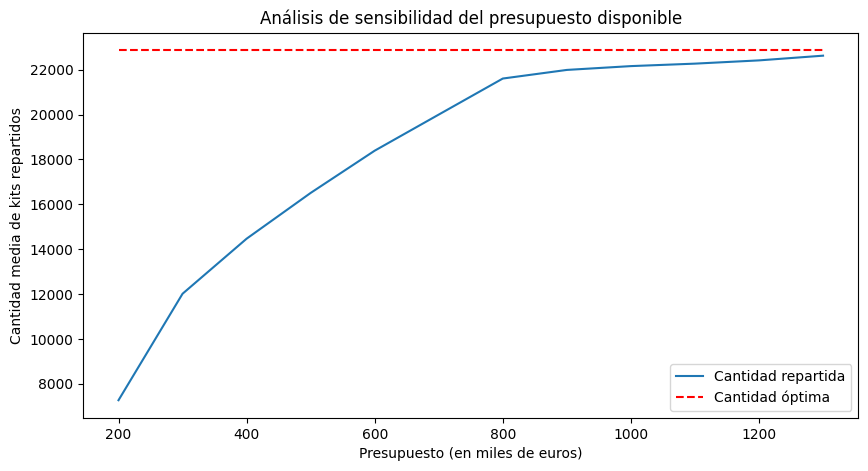

In [ ]:
P=[200,300,400,500,600,700,800,900,1000,1100,1200,1300]
V=[7270,12016,14469,16509,18392,20001,21607,21991,22161,22271,22416,22626]
M=np.ones(len(P))*22869
plt.figure(figsize=(10,5))
plt.plot(P,V,label='Cantidad repartida')
plt.plot(P,M,'--',color='red',label='Cantidad óptima')
plt.xlabel("Presupuesto (en miles de euros)")
plt.ylabel("Cantidad media de kits repartidos")
plt.title("Análisis de sensibilidad del presupuesto disponible")
plt.legend()
plt.show()

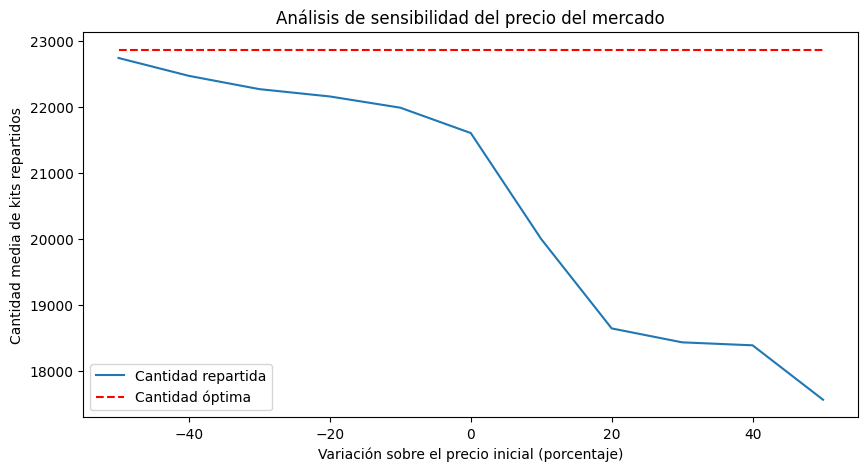

In [ ]:
P=[-50,-40,-30,-20,-10,0,10,20,30,40,50]
V=[22744,22473,22272,22161,21991,21607,20001,18648,18437,18392,17568]
M=np.ones(len(P))*22869
plt.figure(figsize=(10,5))
plt.plot(P,V,label='Cantidad repartida')
plt.plot(P,M,'--',color='red',label='Cantidad óptima')
plt.xlabel("Variación sobre el precio inicial (porcentaje)")
plt.ylabel("Cantidad media de kits repartidos")
plt.title("Análisis de sensibilidad del precio del mercado")
plt.legend()
plt.show()

Graficamos la solución

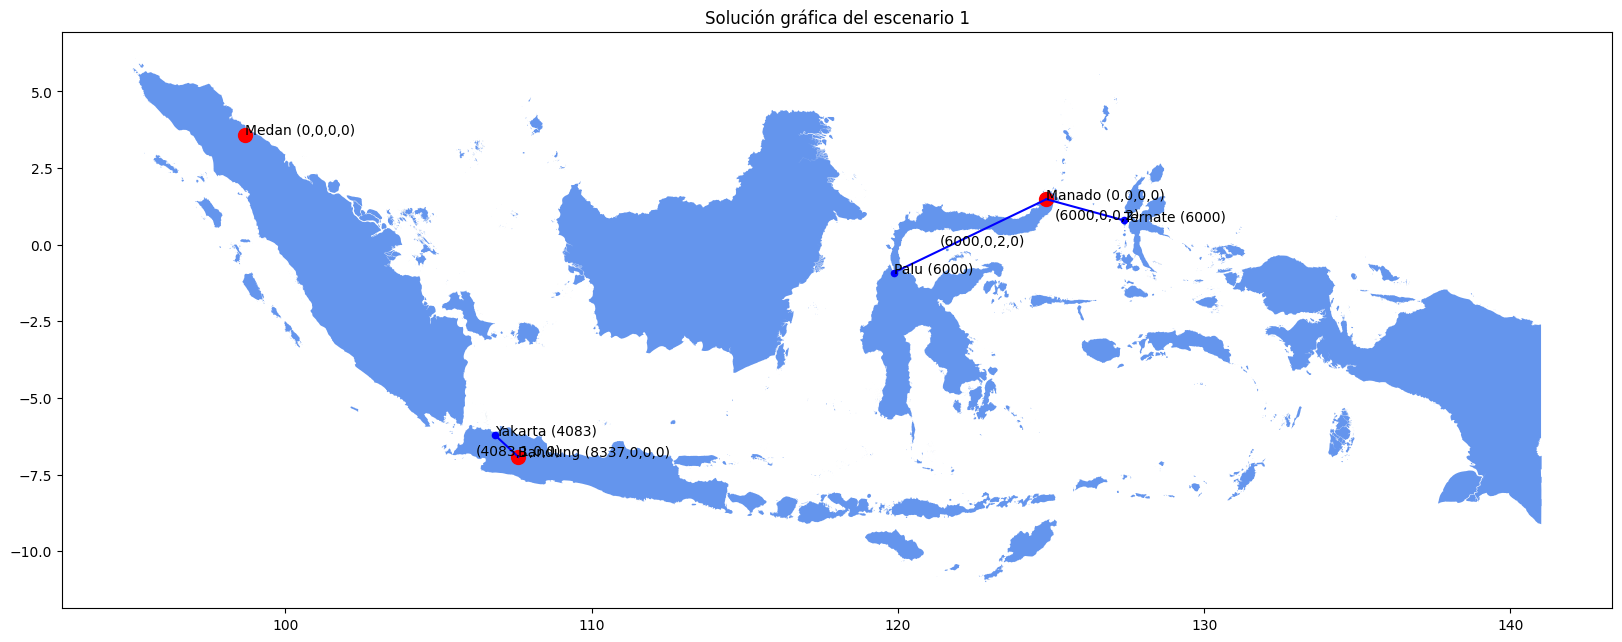

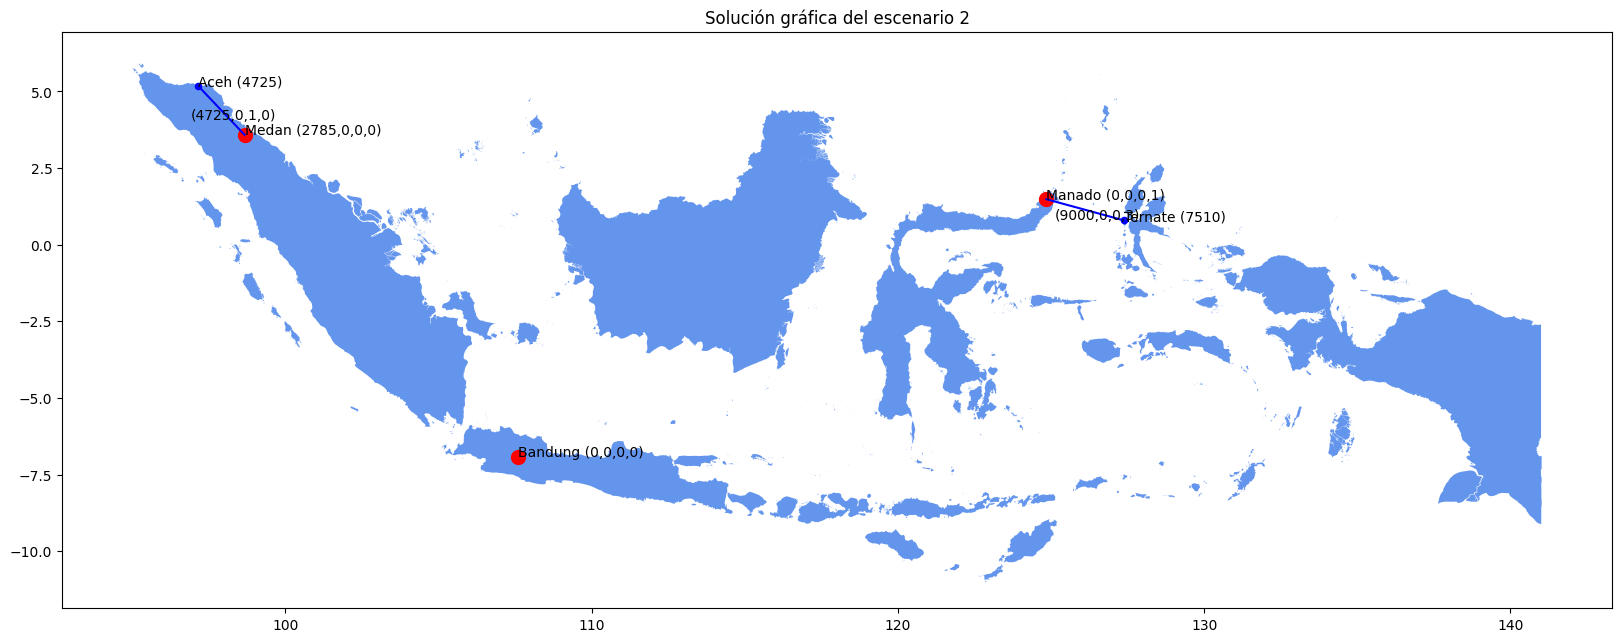

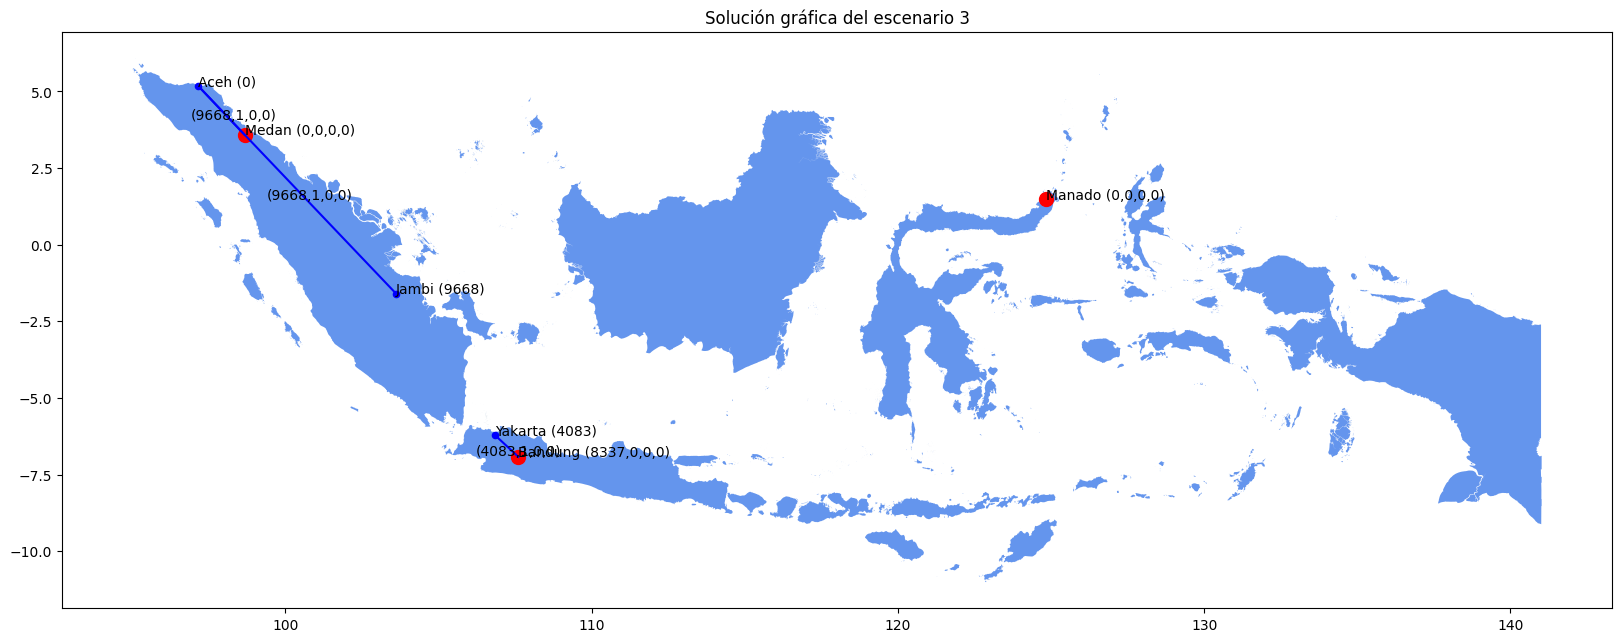

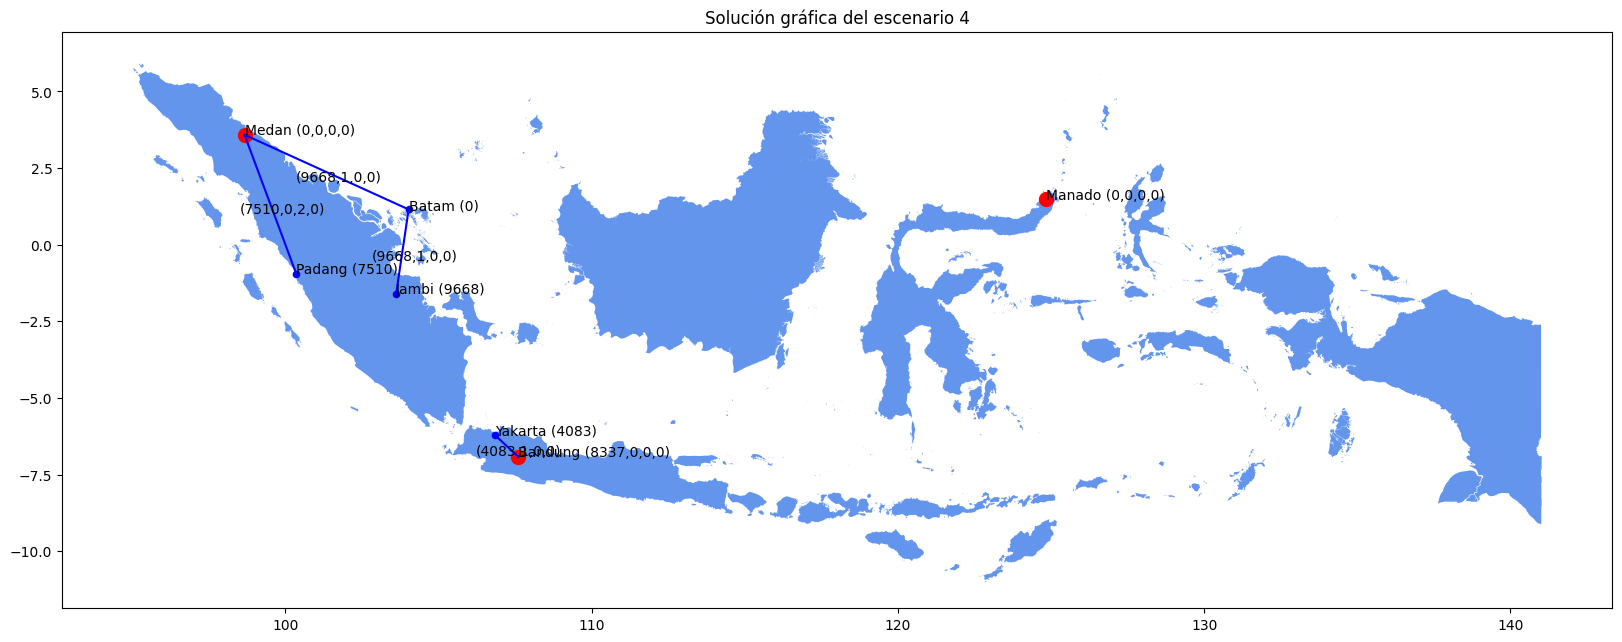

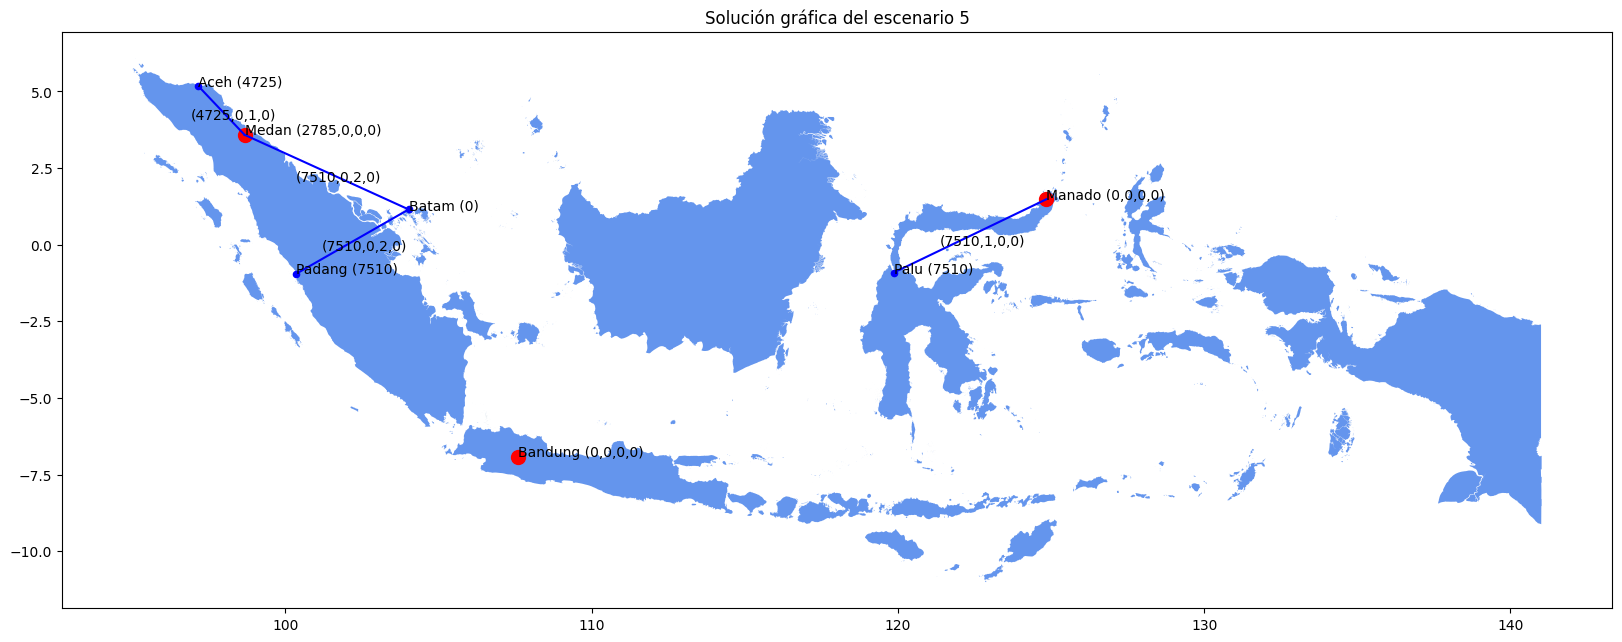

In [ ]:
num_escenarios=5

for e in range(1,num_escenarios+1):

    fig, ax = plt.subplots(figsize=(20,40))
    df_plot.plot(ax=ax, color='cornflowerblue')

    for i in range(len(ciudades)):
        if i+1 in X:
            plt.scatter(float(ciudades[i][1]),float(ciudades[i][0]),color='red',s=100)
            ciudad=ciudades[i][2]

            if ciudades[i][2] in D[e]:
                ciudad=ciudad+f' ({D[e][ciudades[i][2]]},'

            else:
                ciudad=ciudad+' (0,'

            if e in C:

                if (ciudades[i][2],1) in C[e]:
                    ciudad=ciudad+f' ({C[e][(ciudades[i][2],1)]},'
                else:
                    ciudad=ciudad+f'0,'

                if (ciudades[i][2],2) in C[e]:
                    ciudad=ciudad+f'{C[e][(ciudades[i][2],2)]},'
                else:
                    ciudad=ciudad+f'0,'

                if (ciudades[i][2],3) in C[e]:
                    ciudad=ciudad+f'{C[e][(ciudades[i][2],3)]})'
                else:
                    ciudad=ciudad+f'0)'

            else:
                ciudad=ciudad+'0,0,0)'

            plt.annotate(ciudad, (float(ciudades[i][1]),float(ciudades[i][0])))
        for j in range(len(ciudades)):
            if (i+1,j+1) in Y[e]:
                plt.plot([float(ciudades[i][1]),float(ciudades[j][1])],[float(ciudades[i][0]),float(ciudades[j][0])],color='blue')
                plt.scatter(float(ciudades[j][1]),float(ciudades[j][0]),color='blue',s=20)
                if ciudades[j][2] in D[e]:
                    demn=D[e][ciudades[j][2]]
                else:
                    demn=0
                plt.annotate(ciudades[j][2]+f' ({demn})', (float(ciudades[j][1]),float(ciudades[j][0])))
                arista=f'({Y[e][(i+1,j+1)]}'

                if (i+1,j+1,1) in Z[e]:
                    arista=arista+f',{Z[e][(i+1,j+1,1)]}'
                else:
                    arista=arista+',0'

                if (i+1,j+1,2) in Z[e]:
                    arista=arista+f',{Z[e][(i+1,j+1,2)]}'
                else:
                    arista=arista+',0'

                if (i+1,j+1,3) in Z[e]:
                    arista=arista+f',{Z[e][(i+1,j+1,3)]}'
                else:
                    arista=arista+',0'

                arista=arista+')'

                plt.annotate(arista, ((float(ciudades[i][1])+float(ciudades[j][1]))/2-1,(float(ciudades[i][0])+float(ciudades[j][0]))/2-0.3))

    plt.title(f'Solución gráfica del escenario {e}')
    plt.show()